<a href="https://colab.research.google.com/github/uol-mediaprocessing-2021-2022/students_projects-can-i-read-it/blob/main/can%2BI%2Bread%2Bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Output to colab (Quelle: Folien)
import matplotlib
%matplotlib inline

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

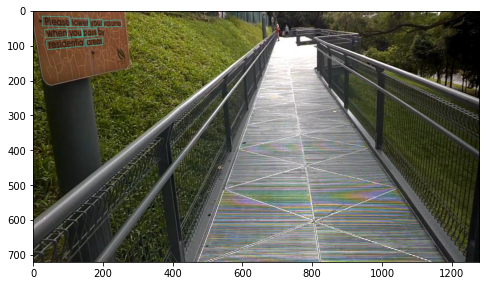

In [37]:
# Set image
img = cv.imread('drive/MyDrive/img_10.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Create a list to store all preprocessed versions
preprocessed_list = []

# Add the original image to the list
preprocessed_list.append(img)

plt.figure(figsize=(8, 8))
plt.imshow(img)

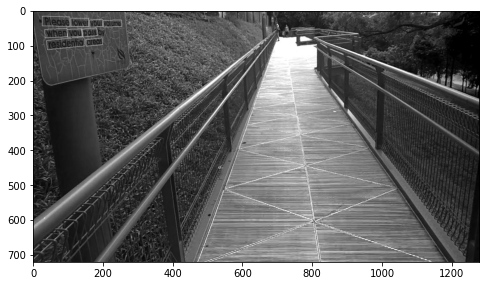

In [38]:
# Create a greyscale copy
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Output image
fig = plt.figure(figsize=(8,8))
plt.imshow(img_gray, cmap = "gray")

# Add greyscale copy to preprocessed List
img_gray = cv.merge((img_gray,img_gray,img_gray)) # Hack for 3 gray channels
preprocessed_list.append(img_gray)

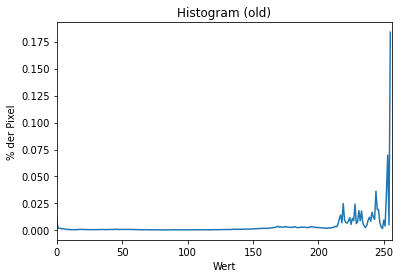

In [8]:
# Histogram berechnen (grayscale)
# Quelle https://www.pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/

histSize = 256
histRange = [0,256]

# Histogram berechenen
hist_old = cv.calcHist([img_gray], [0], None, [histSize], histRange)
hist_old /= hist_old.sum()

# Histogram plotten
plt.figure()
plt.title("Histogram (old)")
plt.xlabel("Wert")
plt.ylabel("% der Pixel")
plt.plot(hist_old)
plt.xlim([0, 256])
plt.show()

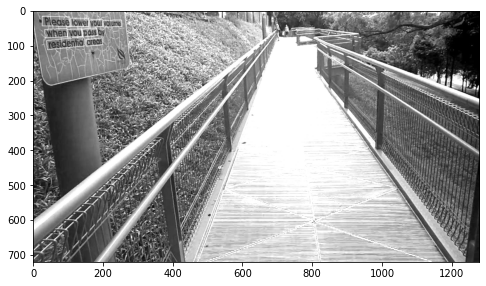

In [39]:
alpha = 2 # Kontrast
beta = 0 # Helligkeit

# Kontrast ändern (grayscale)
img_gray_highK = cv.convertScaleAbs(img_gray, alpha=alpha, beta=beta)

# Bild anzeigen
plt.figure(figsize=(8,8))
plt.imshow(img_gray_highK, cmap='gray')

# Add high contrast greyscale copy to preprocessed list
img_gray_highK = cv.merge((img_gray_highK, img_gray_highK, img_gray_highK)) # Hack for 3 gray channels
preprocessed_list.append(img_gray_highK)

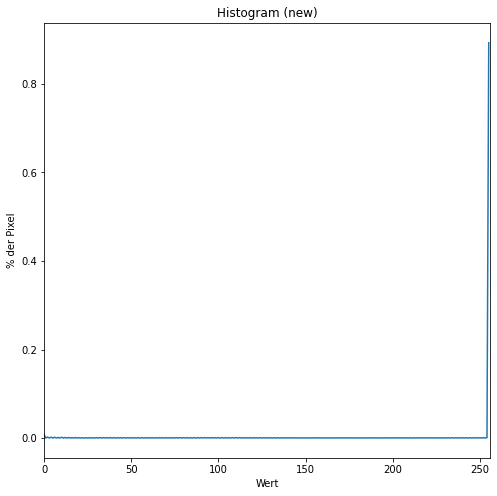

In [13]:
# Neues Histogram berechenen
hist_new = cv.calcHist([img_gray_highK], [0], None, [histSize], histRange)
hist_new /= hist_new.sum()

# Neues Histogram plotten
plt.figure(figsize=(8,8))
plt.title("Histogram (new)")
plt.xlabel("Wert")
plt.ylabel("% der Pixel")
plt.plot(hist_new)
plt.xlim([0, 256])
plt.show()

[INFO] Initializing text detection with EAST [1/3]
[INFO] text detection took 8.799129 seconds
[INFO] Initializing text detection with EAST [2/3]
[INFO] text detection took 8.871807 seconds
[INFO] Initializing text detection with EAST [3/3]


error: ignored

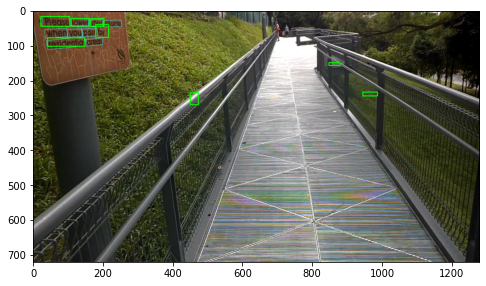

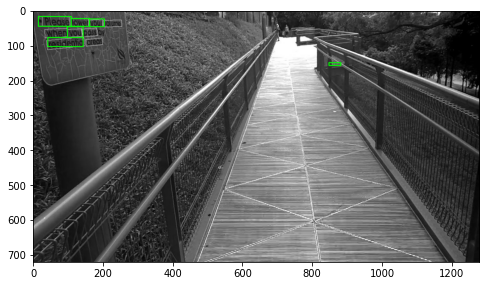

In [41]:
# EAST Anwendung
from imutils.object_detection import non_max_suppression
import time

# Erstelle Liste die die Koordinaten der gefundenen Textstellen in jeweiligen Bild enthält
boxes_list = []

min_score = 0.55 # Wert is anpassbar

for index, preprocessed_img in enumerate(preprocessed_list):
	# Kopie erstellen und Bilddimensionen speichern
	orig = preprocessed_img.copy()
	orig_rectangles = preprocessed_img.copy()
	(H, W) = orig.shape[:2]

	# Bilddimensionen anpassen (müssen Mult. von 32 sein für EAST)
	(newW, newH) = (1280, 1280)
	rW = W / float(newW)
	rH = H / float(newH)

	preprocessed_img = cv.resize(preprocessed_img, (newW, newH))
	(H, W) = preprocessed_img.shape[:2]

	# 2 Layer sind notwendig, die Ausgabe Wahrscheinlichkeiten und die Koordinaten des Texts im Bild
	layerNames = [
		"feature_fusion/Conv_7/Sigmoid",
		"feature_fusion/concat_3"]

	# EAST laden
	print("[INFO] Initializing text detection with EAST [" + str(index + 1) + "/" + str(len(preprocessed_list)) + "]")
	net = cv.dnn.readNet('drive/MyDrive/east/frozen_east_text_detection.pb')

	# Erstelle einen "Blob" und wende das trainierte model an um Output zu generieren
	blob = cv.dnn.blobFromImage(preprocessed_img, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)
	start = time.time()
	net.setInput(blob)
	(scores, geometry) = net.forward(layerNames)
	end = time.time()

	print("[INFO] text detection took {:.6f} seconds".format(end - start))
 
	# Speichere die Menge Zeilen und Säulen in der Matrix mit den Wahrscheinlichkeiten
	# Initiere Sets für die Rechtecke und deren Zuversicht
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# Iteriere durch alle Zeilen
	for y in range(0, numRows):
		# Exctrahiere die Scores sowie deren zugehörige Positions Daten
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# Iteriere durch alle Spalten
		for x in range(0, numCols):
			# Ignoriere zu geringe Scores
			if scoresData[x] < min_score:
				continue
			# Berechne den offset, da der Output 4 Mal kleiner als der Input ist
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
			# Berechne den Roationswinkel
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
			# Berechne die Breite und Länge der Ränder
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
			# Berechne die Koordinaten der Ränder
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
			# Füge die "Box" Koordinaten zu der entsprechenden Liste hinzu
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
		
	# Eliminiere überlappende Boxen mithilfe von non_max_suppression
	boxes = non_max_suppression(np.array(rects), probs=confidences)
 
	# Füge die Boxen der Liste zu
	boxes_list.append(boxes)

	# Iteriere über alle Boxen
	for (startX, startY, endX, endY) in boxes:
		# Skaliere die Boxen
		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)
		# Zeiche die Boxen auf den Output Bild
		cv.rectangle(orig_rectangles, (startX, startY), (endX, endY), (0, 255, 0), 2)
	
	# Zeige das Output
	plt.figure(figsize = (8, 8))
	plt.imshow(orig_rectangles, cmap='gray')

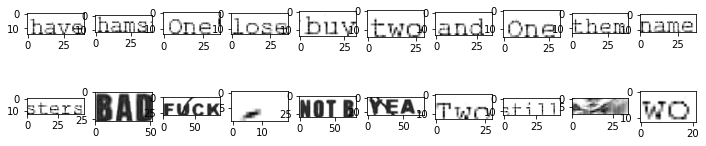

In [35]:
index = 0 # Setze gewünschten Index

# Croppe alle Textboxen aus einen Bild
fig = plt.figure(figsize=(12, 15))

for index, (startX, startY, endX, endY) in enumerate(boxes_list[index]):
  cropped_img = orig[int(startY * rH):int(endY * rH), int(startX * rW):int(endX * rW)]
  fig.add_subplot(10, 10, index+1)
  plt.imshow(cropped_img)

plt.show()

#TODO SORTIEREN
